In [1]:
#PETE 648 FINAL PROJECT: PTA
#KITTIPONG LIMCHUCHUA

import numpy as np
import math
import scipy.special as sci
from matplotlib import pyplot as plt

Name_plot = 114947

#This is build up test
#This is a gas well, use pseudo-pressure and pseudo-time and work as a liquid case

type = 'Finite Conductivity Vertical fractured well + WBS'
test_type = 'Buildup'
rate_type = 'single rate'
pressure_type = 'pressure'

#reservoir properties
phi_data = 0.088*(1-0.131) #0.088
h_data = 170

cr_data = 0
cg_data = 5.097542413316822e-05
ct_data = cr_data + cg_data
rw_data = 0.333
visc_data = 0.03604856910532351
#DPwf_data 
Bo_data = 0.5483710452483469
Pi_data = 7540.132771577818

#assume
qo_data = 2400
tp_data = 3229

#unknown parameters
k_match = 0.016 
xf_match =  119 
FcD_match = 4 #3.5 
CDf_match = 1.6e-4 
#skin_match

#smoothing derivative
L_smooth = 0.15

In [2]:
#import dataset from xlsx
import xlrd
#import col 0: shut-in time (t) 
#import col 1: pressure data (Pws)

N_data = 13800 #13898
N_data_q = 4836
res_Excel = xlrd.open_workbook('Python_welltest_114947_Input.xlsx')

# read pressure form Excel file
if test_type == 'Drawdown':  
    t = np.zeros((N_data,1))
    Pwf = np.zeros((N_data,1)) #declare Pwf array here
    DPwf = np.zeros((N_data,1))
    
    for i in range (0,N_data):
        t[i] = res_Excel.sheet_by_name('pressure').cell(i,0).value
        Pwf[i] = res_Excel.sheet_by_name('pressure').cell(i,1).value
        DPwf[i] = res_Excel.sheet_by_name('pressure').cell(0,1).value - res_Excel.sheet_by_name('pressure').cell(i,1).value

elif test_type == 'Buildup': 
    dt = np.zeros((N_data,1))
    Pws = np.zeros((N_data,1))
    DPws = np.zeros((N_data,1))
    
    if pressure_type == 'Differential Pressure':
        for i in range (0,N_data):
            dt[i] = res_Excel.sheet_by_name('pressure').cell(i,0).value
            DPws[i] = res_Excel.sheet_by_name('pressure').cell(i,1).value
    else:
        for i in range (0,N_data):
            dt[i] = res_Excel.sheet_by_name('pressure').cell(i,0).value
            Pws[i] = res_Excel.sheet_by_name('pressure').cell(i,1).value
            DPws[i] = res_Excel.sheet_by_name('pressure').cell(i,1).value- res_Excel.sheet_by_name('pressure').cell(0,1).value

        
# superposition time-plotting function + Well test derivative calculation
if test_type == 'Drawdown': 
    
    ln_t = np.log(t)
    
    #DPwf calculation
    DPwf_prime = np.zeros((N_data,1))
    for i in range (0,N_data):
        if i == 0:
            DPwf_prime[i] = 0
        elif i == N_data-1:
            DPwf_prime[i] = 0
        elif i == 1 and t[i-1] == 0:
            DPwf_prime[i] = 0
        else:
            iL = i-1
            iR = i+1
            iL_limit = i
            iR_limit = N_data - 1 - i
            i_count = 1
            while (np.log10(t[i]/t[iL])<L_smooth or np.log10(t[iR]/t[i])<L_smooth) and i_count<np.minimum(iL_limit,iR_limit):
                iL -= 1
                iR += 1
                i_count += 1

            DPwf_prime[i] = ((DPwf[i]-DPwf[iL])/(ln_t[i]-ln_t[iL])**2+(DPwf[iR]-DPwf[i])/(ln_t[iR]-ln_t[i])**2)/(1/(ln_t[i]-ln_t[iL])+1/(ln_t[iR]-ln_t[i]))

    #generate dataset for match
    pD_match = k_match*h_data/141.2/visc_data/qo_data/Bo_data*DPwf
    pD_prime_match = k_match*h_data/141.2/visc_data/qo_data/Bo_data*DPwf_prime
    pD_beta_match = pD_prime_match/pD_match
    tD_match = 2.637e-4*k_match*t/phi_data/visc_data/ct_data/rw_data_adj**2     
            
            
elif test_type == 'Buildup': 
    
    if rate_type == 'variable rate':
        tp = np.zeros((N_data_q,1))
        qo = np.zeros((N_data_q,1))
        for j in range (0,N_data_q):
            tp[j] = res_Excel.sheet_by_name('rate').cell(j,0).value
            qo[j] = res_Excel.sheet_by_name('rate').cell(j,1).value

        #ln_ts calculation
        ln_ts = np.zeros((N_data,1))
        for i in range (0,N_data):
            sum_ln_ts = 0
            for j in range (0,N_data_q):
                if j == 0:
                    sum_ln_ts += qo[j]*np.log(tp[N_data_q-1]+dt[i])   #N_data_q minus 1 because python index begins with 0
                else:
                    sum_ln_ts += (qo[j]-qo[j-1])*np.log(tp[N_data_q-1]+dt[i]-tp[j-1])
                ln_ts[i] = sum_ln_ts/qo[N_data_q-1]

        #ln_tps calculation
        ln_tps = 0
        sum_ln_tps = 0
        for j in range (0,N_data_q):
            if j == 0:
                sum_ln_tps += qo[j]*np.log(tp[N_data_q-1])   #N_data_q minus 1 because python index begins with 0
            else:
                sum_ln_tps += (qo[j]-qo[j-1])*np.log(tp[N_data_q-1]-tp[j-1])
            ln_tps = sum_ln_tps/qo[N_data_q-1]

        #ln_dts calculation
        ln_dts = np.zeros((N_data,1))
        for i in range (0,N_data):
            ln_dts[i] = ln_tps+np.log(dt[i])-ln_ts[i]
        qo_data = qo[N_data_q-1]

    else:
        # Compute dts, DPws and DPws' for a single-rate before shut-in 
        tp = tp_data

        dts = tp*dt/(tp+dt)
        ln_dts = np.log(dts)

    dts = np.exp(ln_dts)
    
    #DPws calculation
    DPws_prime = np.zeros((N_data,1))
    for i in range (0,N_data):
        if i == 0:
            DPws_prime[i] = 0
        elif i == N_data-1:
            DPws_prime[i] = 0
        elif i == 1 and dt[i-1] == 0:
            DPws_prime[i] = 0
        else:
            iL = i-1
            iR = i+1
            iL_limit = i
            iR_limit = N_data - 1 - i
            i_count = 1
            while (np.log10(dts[i]/dts[iL])<L_smooth or np.log10(dts[iR]/dts[i])<L_smooth) and i_count<np.minimum(iL_limit,iR_limit):
                iL -= 1
                iR += 1
                i_count += 1

            DPws_prime[i] = ((DPws[i]-DPws[iL])/(ln_dts[i]-ln_dts[iL])**2+(DPws[iR]-DPws[i])/(ln_dts[iR]-ln_dts[i])**2)/(1/(ln_dts[i]-ln_dts[iL])+1/(ln_dts[iR]-ln_dts[i]))


    dts = np.exp(ln_dts)

#generate dataset for match
pD_match = k_match*h_data/141.2/visc_data/qo_data/Bo_data*DPws
pD_prime_match = k_match*h_data/141.2/visc_data/qo_data/Bo_data*DPws_prime
pD_beta_match = pD_prime_match/pD_match
tD_match = 2.637e-4*k_match*dts/phi_data/visc_data/ct_data/xf_match**2

C:\Users\Kittipong Limchuchua\Anaconda3\lib\site-packages\ipykernel_launcher.py:112: RuntimeWarning: divide by zero encountered in log
C:\Users\Kittipong Limchuchua\Anaconda3\lib\site-packages\ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in true_divide


In [3]:
# Define the type of flow behavior here
import numpy as np
import math
import scipy.special as sci
from matplotlib import pyplot as plt
import scipy.integrate as integrate
from scipy.integrate import quad

def Gaver_Stehfest_Finite_Cond(n,t,FcD,CDf,isDiff):
    if n % 2 == 0:
        sum = 0;
        for i in range (1,n+1): #i = 1:n in MATLAB
            sum = sum+Vi(n,i)*fs_TPR(np.log(2)/t*i,FcD,CDf,isDiff)
        
        sum = sum*np.log(2)/t
        return sum

def Vi(n,i):
    sum = 0
    for k in range(int(np.round((i+1)/2,1)), int(min(i,n/2)+1)):
        sum = sum + (k**(n/2))*math.factorial(2*k)/math.factorial(n/2-k)/math.factorial(k)/math.factorial(k-1)/math.factorial(i-k)/math.factorial(2*k-i)   

    sum = sum *(-1)**(n/2+i)
    return sum

def fs_InfCon(s,FcD):

        xD = xD_correct(FcD)
        return_fs_InfCon_term1 = integrate.quad(lambda z: sci.kn(0,z),0,np.sqrt(s)*(1+xD))
        return_fs_InfCon_term2 = integrate.quad(lambda z: sci.kn(0,z),0,np.sqrt(s)*(1-xD))
        return_fs_InfCon = (return_fs_InfCon_term1[0]+return_fs_InfCon_term2[0])*1/2/s/np.sqrt(s)
        return return_fs_InfCon
def pD_LBD(s,FcD,sf):
    alpha = np.sqrt(s+np.sqrt(s))
    eta_f = 200*FcD
    psi = np.sqrt(2/FcD*alpha/(1+alpha*sf)+s/eta_f)
    return np.pi/s/FcD/psi/np.tanh(psi)
 
def xD_correct(FcD):
    a0 = 0.759919;
    a1 = 0.465301;
    a2 = 0.562754;
    a3 = 0.363093;
    a4 = 0.0298881;
    b0 = 1;
    b1 = 0.994770;
    b2 = 0.896679;
    b3 = 0.430707;
    b4 = 0.0467339;
    
    return (a0 + a1*np.log(FcD)+ a2*(np.log(FcD))**2 + a3*(np.log(FcD))**3 + a4*(np.log(FcD))**4)/(b0 + b1*np.log(FcD)+ b2*(np.log(FcD))**2 + b3*(np.log(FcD))**3 + b4*(np.log(FcD))**4)

def fs_TPR(s,FcD,CDf,isDiff):
    
    return_fs = pD_LBD(s,FcD,0) - pD_LBD(s,10000,0) + fs_InfCon(s,FcD)
    return_fs = 1/(1/return_fs+s**2*CDf) #Incorporate WBS
    if isDiff == 1:
        return s*return_fs
    else:
        return return_fs

#generate dataset for model
n = 8
num_t_count_mod = 1000
tD_mod = np.logspace(-6,5,num = num_t_count_mod)
pD_mod = np.zeros((num_t_count_mod,1))
pD_prime_mod = np.zeros((num_t_count_mod,1))
pD_beta_mod = np.zeros((num_t_count_mod,1))

FcD_test = 10

for t_count in range(0,num_t_count_mod):
    pD_mod[t_count] = Gaver_Stehfest_Finite_Cond(n,tD_mod[t_count],FcD_match,CDf_match,0)
    pD_prime_mod[t_count] = tD_mod[t_count]*Gaver_Stehfest_Finite_Cond(n,tD_mod[t_count],FcD_match,CDf_match,1)
    pD_beta_mod[t_count] = pD_prime_mod[t_count]/pD_mod[t_count]

C:\Users\Kittipong Limchuchua\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  
C:\Users\Kittipong Limchuchua\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  


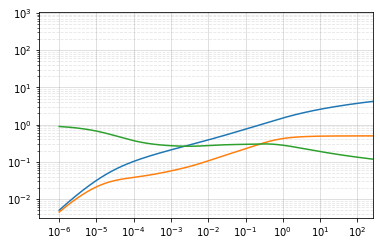

In [4]:
#for testing purpose
plt.loglog(tD_mod,pD_mod, label = r'$p_{D}$' +' Model')
plt.loglog(tD_mod,pD_prime_mod, label = r'$p_{Dd}$' +' Model')
plt.loglog(tD_mod,pD_beta_mod, label = r'$p_{Dd\beta}$' +' Model')

ax = plt.gca()
ax.set_aspect('equal')
ax.axis([np.min(tD_match)/1000, np.max(tD_match)*1000, np.min(pD_match)/1000, np.max(pD_match)*1000])
import matplotlib.ticker as ticker
locmaj = ticker.LogLocator(base=10,numticks=14) 
ax.xaxis.set_major_locator(locmaj)

plt.grid(b=True, which='major', color=(0.5,0.5,0.5), alpha = 0.3, linestyle='-')
plt.grid(b=True, which='minor', color=(0.5,0.5,0.5), alpha = 0.2, linestyle='--')

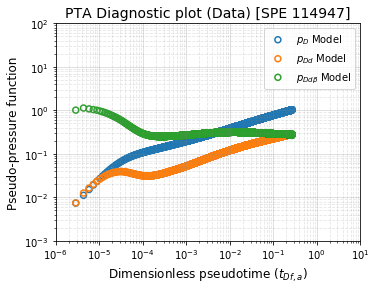

<Figure size 3600x3600 with 0 Axes>

In [5]:
#THIS IS FOR THE DATA PLOT (LOG-LOG)
Diagnostic_Data_plot = plt.figure()
#plot data from model
#plt.loglog(tD_mod,pD_mod, label = r'$p_{D}$' +' Model')
#plt.loglog(tD_mod,pD_prime_mod, label = r'$p_{Dd}$' +' Model')
#plt.loglog(tD_mod,pD_beta_mod, label = r'$p_{Dd\beta}$' +' Model')

#plot data fron the match
      #cut pD_prime at the end
tD_match_cutends = np.delete(tD_match,N_data-1,0)
pD_match_cutends = np.delete(pD_match,N_data-1,0)
pD_prime_match_cutends = np.delete(pD_prime_match,N_data-1,0)    
pD_beta_match_cutends = np.delete(pD_beta_match,N_data-1,0)    

      #cut pD_prime at the beginning if there is still more DPws' = 0
while pD_prime_match_cutends[0] == 0:
    tD_match_cutends = np.delete(tD_match_cutends,0,0)
    pD_match_cutends = np.delete(pD_match_cutends,0,0)
    pD_prime_match_cutends = np.delete(pD_prime_match_cutends,0,0) 
    pD_beta_match_cutends = np.delete(pD_beta_match_cutends,0,0)  
    
plt.plot()
plt.scatter(tD_match_cutends,pD_match_cutends,facecolors='none', edgecolors='C0',linewidth=1.5,label = r'$p_{D}$' +' Model')
plt.scatter(tD_match_cutends,pD_prime_match_cutends,facecolors='none', edgecolors='C1',linewidth=1.5,label = r'$p_{Dd}$' +' Model')
plt.scatter(tD_match_cutends,pD_beta_match_cutends,facecolors='none', edgecolors='C2',linewidth=1.5,label = r'$p_{Dd\beta}$' +' Model')

plt.xscale('log')
plt.yscale('log')

#control legend + plotting mechanics 
plt.title('PTA Diagnostic plot (Data) [SPE ' + str(Name_plot) + ']',fontsize=14)
plt.legend()


plt.xlabel('Dimensionless pseudotime ' + r'$(t_{Df,a})$',fontsize=12)
plt.ylabel('Pseudo-pressure function',fontsize=12)

ax = plt.gca()
ax.set_aspect('equal')
ax.axis([1e-6, 1e+1, 1e-3, 1e+2])

import matplotlib.ticker as ticker
locmaj = ticker.LogLocator(base=10,numticks=14) 
ax.xaxis.set_major_locator(locmaj)

plt.grid(b=True, which='major', color=(0.5,0.5,0.5), alpha = 0.3, linestyle='-')
plt.grid(b=True, which='minor', color=(0.5,0.5,0.5), alpha = 0.2, linestyle='--')
plt.figure(figsize=(50,50))
Diagnostic_Data_plot.savefig(str(Name_plot)+'_Diagnostic_Data.png', dpi=500)

No handles with labels found to put in legend.


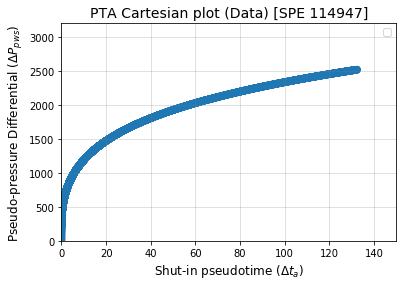

<Figure size 3600x3600 with 0 Axes>

In [10]:
#THIS IS FOR THE DATA PLOT (Cartesian)
Cartesian_Data_plot = plt.figure()
#plot data from model

    
plt.plot()
plt.scatter(dt,DPws,facecolors='none', edgecolors='C0',linewidth=1.5)

#control legend + plotting mechanics 
plt.title('PTA Cartesian plot (Data) [SPE ' + str(Name_plot) + ']',fontsize=14)
plt.legend()


plt.xlabel('Shut-in pseudotime ' + r'$(\Delta t_{a})$',fontsize=12)
plt.ylabel('Pseudo-pressure Differential ' + r'$(\Delta P_{pws})$',fontsize=12)

ax = plt.gca()
#ax.set_aspect('equal')
ax.axis([0, 150, 0, 3200])

import matplotlib.ticker as ticker
#locmaj = ticker.LogLocator(base=10,numticks=14) 
#ax.xaxis.set_major_locator(locmaj)

plt.grid(b=True, which='major', color=(0.5,0.5,0.5), alpha = 0.3, linestyle='-')
plt.grid(b=True, which='minor', color=(0.5,0.5,0.5), alpha = 0.2, linestyle='--')
plt.figure(figsize=(50,50))
Cartesian_Data_plot.savefig(str(Name_plot)+'_Cartesian_Data.png', dpi=500)

C:\Users\Kittipong Limchuchua\Anaconda3\lib\site-packages\ipykernel_launcher.py:39: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
C:\Users\Kittipong Limchuchua\Anaconda3\lib\site-packages\ipykernel_launcher.py:39: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


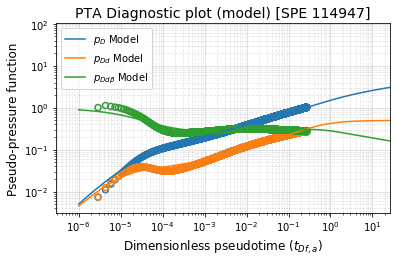

<Figure size 3600x3600 with 0 Axes>

In [11]:
Diagnostic_plot = plt.figure()
#plot data from model
plt.loglog(tD_mod,pD_mod, label = r'$p_{D}$' +' Model')
plt.loglog(tD_mod,pD_prime_mod, label = r'$p_{Dd}$' +' Model')
plt.loglog(tD_mod,pD_beta_mod, label = r'$p_{Dd\beta}$' +' Model')

#plot data fron the match
      #cut pD_prime at the end
tD_match_cutends = np.delete(tD_match,N_data-1,0)
pD_match_cutends = np.delete(pD_match,N_data-1,0)
pD_prime_match_cutends = np.delete(pD_prime_match,N_data-1,0)    
pD_beta_match_cutends = np.delete(pD_beta_match,N_data-1,0)    

      #cut pD_prime at the beginning if there is still more DPws' = 0
while pD_prime_match_cutends[0] == 0:
    tD_match_cutends = np.delete(tD_match_cutends,0,0)
    pD_match_cutends = np.delete(pD_match_cutends,0,0)
    pD_prime_match_cutends = np.delete(pD_prime_match_cutends,0,0) 
    pD_beta_match_cutends = np.delete(pD_beta_match_cutends,0,0)  
    
plt.plot()
plt.scatter(tD_match_cutends,pD_match_cutends,facecolors='none', edgecolors='C0',linewidth=1.5)
plt.scatter(tD_match_cutends,pD_prime_match_cutends,facecolors='none', edgecolors='C1',linewidth=1.5)
plt.scatter(tD_match_cutends,pD_beta_match_cutends,facecolors='none', edgecolors='C2',linewidth=1.5)

plt.xscale('log')
plt.yscale('log')

#control legend + plotting mechanics 
plt.title('PTA Diagnostic plot (model) [SPE ' + str(Name_plot) + ']',fontsize=14)
plt.legend()


plt.xlabel('Dimensionless pseudotime ' + r'$(t_{Df,a})$',fontsize=12)
plt.ylabel('Pseudo-pressure function',fontsize=12)

ax = plt.gca()
ax.set_aspect('equal')
ax.axis([np.min(tD_match)/100, np.max(tD_match)*100, np.min(pD_match)/100, np.max(pD_match)*100])

import matplotlib.ticker as ticker
locmaj = ticker.LogLocator(base=10,numticks=14) 
ax.xaxis.set_major_locator(locmaj)

plt.grid(b=True, which='major', color=(0.5,0.5,0.5), alpha = 0.3, linestyle='-')
plt.grid(b=True, which='minor', color=(0.5,0.5,0.5), alpha = 0.2, linestyle='--')
plt.figure(figsize=(50,50))
Diagnostic_plot.savefig(str(Name_plot)+'_Diagnostic.png', dpi=500)

In [ ]:
Semilog_plot = plt.figure()
#semi-log plot
#plot data from model
plt.plot(tD_mod,pD_mod, label = r'$p_{D}$' +' Model')
plt.plot(tD_mod,pD_prime_mod, label = r'$p_{Dd}$' +' Model')

#plot data fron the match
      #cut pD_prime at the end
tD_match_cutends = np.delete(tD_match,N_data-1,0)
pD_match_cutends = np.delete(pD_match,N_data-1,0)
pD_prime_match_cutends = np.delete(pD_prime_match,N_data-1,0)      

      #cut pD_prime at the beginning if there is still more DPws' = 0
while pD_prime_match_cutends[0] == 0:
    tD_match_cutends = np.delete(tD_match_cutends,0,0)
    pD_match_cutends = np.delete(pD_match_cutends,0,0)
    pD_prime_match_cutends = np.delete(pD_prime_match_cutends,0,0)  
    
plt.plot()
plt.scatter(tD_match_cutends,pD_match_cutends,facecolors='none', edgecolors='C0',linewidth=1.5)
plt.scatter(tD_match_cutends,pD_prime_match_cutends,facecolors='none', edgecolors='C1',linewidth=1.5)

plt.xscale('log')
#plt.yscale('log')

#control legend + plotting mechanics 
plt.title('PTA Semi-log plot (model) [SPE ' + str(Name_plot) + ']',fontsize=14)
plt.legend()


plt.xlabel('Dimensionless pseudotime ' + r'$(t_{Df,a})$',fontsize=12)
plt.ylabel('Pseudo-pressure function',fontsize=12)

ax = plt.gca()
ax.axis([np.min(tD_match)/100, np.max(tD_match)*100, np.min(pD_match), np.max(pD_match)*1.2])
plt.grid(b=True, which='major', color=(0.5,0.5,0.5), alpha = 0.3, linestyle='-')
plt.grid(b=True, which='minor', color=(0.5,0.5,0.5), alpha = 0.2, linestyle='--')
plt.figure(figsize=(20,20))
Semilog_plot.savefig(str(Name_plot)+'_Semilog.png', dpi=500)

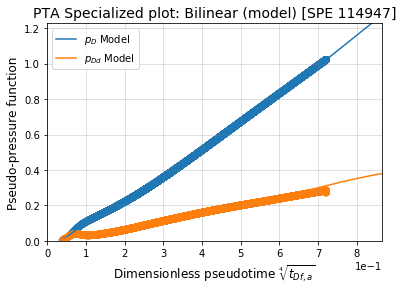

<Figure size 1440x1440 with 0 Axes>

In [12]:
one_fourth_plot = plt.figure()
# Sqrt(t) plot
#plot data from model
plt.plot(tD_mod**0.25,pD_mod, label = r'$p_{D}$' +' Model')
plt.plot(tD_mod**0.25,pD_prime_mod, label = r'$p_{Dd}$' +' Model')

#plot data fron the match
      #cut pD_prime at the end
tD_match_cutends = np.delete(tD_match,N_data-1,0)
pD_match_cutends = np.delete(pD_match,N_data-1,0)
pD_prime_match_cutends = np.delete(pD_prime_match,N_data-1,0)      

      #cut pD_prime at the beginning if there is still more DPws' = 0
while pD_prime_match_cutends[0] == 0:
    tD_match_cutends = np.delete(tD_match_cutends,0,0)
    pD_match_cutends = np.delete(pD_match_cutends,0,0)
    pD_prime_match_cutends = np.delete(pD_prime_match_cutends,0,0)  
    
plt.plot()
plt.scatter(tD_match_cutends**0.25,pD_match_cutends,facecolors='none', edgecolors='C0',linewidth=1.5)
plt.scatter(tD_match_cutends**0.25,pD_prime_match_cutends,facecolors='none', edgecolors='C1',linewidth=1.5)


#plt.xscale('log')
#plt.yscale('log')

#control legend + plotting mechanics 
plt.title('PTA Specialized plot: Bilinear (model) [SPE ' + str(Name_plot) + ']',fontsize=14)
plt.legend()


plt.xlabel('Dimensionless pseudotime ' + r'$\sqrt[4]{t_{Df,a}}$',fontsize=12)
plt.ylabel('Pseudo-pressure function',fontsize=12)

ax = plt.gca()
ax.axis([np.min(tD_match**0.25), np.max(tD_match**0.25*1.2), np.min(pD_match), np.max(pD_match)*1.2])
plt.grid(b=True, which='major', color=(0.5,0.5,0.5), alpha = 0.3, linestyle='-')
plt.grid(b=True, which='minor', color=(0.5,0.5,0.5), alpha = 0.2, linestyle='--')
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.figure(figsize=(20,20))
one_fourth_plot.savefig(str(Name_plot)+'_One_Fourth.png', dpi=500)

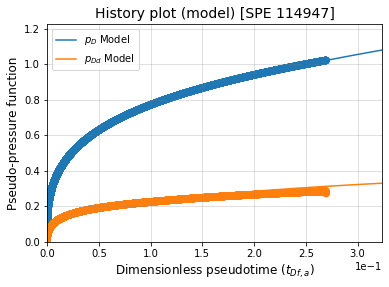

<Figure size 1440x1440 with 0 Axes>

In [13]:
Cartesian_plot = plt.figure()
#History plot
#plot data from model
plt.plot(tD_mod,pD_mod, label = r'$p_{D}$' +' Model')
plt.plot(tD_mod,pD_prime_mod, label = r'$p_{Dd}$' +' Model')

#plot data fron the match
      #cut pD_prime at the end
tD_match_cutends = np.delete(tD_match,N_data-1,0)
pD_match_cutends = np.delete(pD_match,N_data-1,0)
pD_prime_match_cutends = np.delete(pD_prime_match,N_data-1,0)      

      #cut pD_prime at the beginning if there is still more DPws' = 0
while pD_prime_match_cutends[0] == 0:
    tD_match_cutends = np.delete(tD_match_cutends,0,0)
    pD_match_cutends = np.delete(pD_match_cutends,0,0)
    pD_prime_match_cutends = np.delete(pD_prime_match_cutends,0,0)  
    
plt.plot()
plt.scatter(tD_match_cutends,pD_match_cutends,facecolors='none', edgecolors='C0',linewidth=1.5)
plt.scatter(tD_match_cutends,pD_prime_match_cutends,facecolors='none', edgecolors='C1',linewidth=1.5)

#plt.xscale('log')
#plt.yscale('log')

#control legend + plotting mechanics 
plt.title('History plot (model) [SPE ' + str(Name_plot) + ']',fontsize=14)
plt.legend()


plt.xlabel('Dimensionless pseudotime ' + r'$(t_{Df,a})$',fontsize=12)
plt.ylabel('Pseudo-pressure function',fontsize=12)

ax = plt.gca()
ax.axis([np.min(tD_match), np.max(tD_match)*1.2, np.min(pD_match), np.max(pD_match)*1.2])
plt.grid(b=True, which='major', color=(0.5,0.5,0.5), alpha = 0.3, linestyle='-')
plt.grid(b=True, which='minor', color=(0.5,0.5,0.5), alpha = 0.2, linestyle='--')
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.figure(figsize=(20,20))
Cartesian_plot.savefig(str(Name_plot)+'_Cartesian.png', dpi=500)

In [ ]:
#error report
Opt_matrix = np.zeros((N_data,5))

for i in range (0,N_data):
    Opt_matrix[i,0] = tD_match[i]
    Opt_matrix[i,1] = Gaver_Stehfest_Finite_Cond(n,tD_match[i],FcD_match,CDf_match,0)
    Opt_matrix[i,2] = k_match*h_data/141.2/visc_data/qo_data/Bo_data*DPws[i]
    Opt_matrix[i,3] = tD_match[i]*Gaver_Stehfest_Finite_Cond(n,tD_match[i],FcD_match,CDf_match,1)
    Opt_matrix[i,4] = k_match*h_data/141.2/visc_data/qo_data/Bo_data*DPws_prime[i]
    
if tD_match[0] == 0:
    Opt_matrix_str = np.delete(Opt_matrix,0,0)
    Opt_matrix = Opt_matrix_str

sum_sqr = 0
for i in range (0,Opt_matrix.shape[0]):
    if Opt_matrix[i,1] !=0 and Opt_matrix[i,2] != 0:
        sum_sqr += (Opt_matrix[i,1]-Opt_matrix[i,2])**2
    if Opt_matrix[i,3] !=0 and Opt_matrix[i,4] != 0:
        sum_sqr += (Opt_matrix[i,3]-Opt_matrix[i,4])**2
   
print(sum_sqr)

In [ ]:
#optimization box
def Sum_sqr_error(k_val,xf_val,FcD_val,CDf_val):
    
    Opt_matrix_local = np.zeros((N_data,5))
    tD_val = 2.637e-4*k_val*dts/phi_data/visc_data/ct_data/xf_val**2

    for i in range (0,N_data):
        Opt_matrix_local[i,0] = tD_val[i] 
        Opt_matrix_local[i,1] = Gaver_Stehfest_Finite_Cond(n,tD_val[i],FcD_val,CDf_val,0)
        Opt_matrix_local[i,2] = k_val*h_data/141.2/visc_data/qo_data/Bo_data*DPws[i]
        Opt_matrix_local[i,3] = tD_val[i]*Gaver_Stehfest_Finite_Cond(n,tD_val[i],FcD_val,CDf_val,1)
        Opt_matrix_local[i,4] = k_val*h_data/141.2/visc_data/qo_data/Bo_data*DPws_prime[i]
    
    if tD_match[0] == 0:
        Opt_matrix_str_local = np.delete(Opt_matrix_local,0,0)
        Opt_matrix_local = Opt_matrix_str_local
    
    sum_sqr_local = 0
    for i in range (0,Opt_matrix_local.shape[0]):
        if Opt_matrix_local[i,1] !=0 and Opt_matrix_local[i,2] != 0:
            sum_sqr_local += (Opt_matrix_local[i,1]-Opt_matrix_local[i,2])**2
            
    for i in range (0,Opt_matrix_local.shape[0]-1):
        if Opt_matrix_local[i,3] !=0 and Opt_matrix_local[i,4] != 0:
            sum_sqr_local += (Opt_matrix_local[i,3]-Opt_matrix_local[i,4])**2

    return sum_sqr_local

def eggholder(Opt_var):
    return Sum_sqr_error(Opt_var[0],Opt_var[1],Opt_var[2],Opt_var[3])

bounds = [(0.013, 0.017), (100, 110),(3,5),(0,5e-4)]

from scipy import optimize
results = dict()
results['shgo'] = optimize.shgo(eggholder, bounds)
results['shgo']

In [14]:
C_match = CDf_match*(141.2*24/3792/phi_data/h_data/ct_data/xf_match**2)**(-1)
print(C_match)

0.0016801517692078467
